# 20.MARL

## 20.1 Intro

Multi-Agent Reinforcement Learning (MARL)
多智能体强化学习

## 20.2. Modeling

元组$(N, \mathcal{S, A, R, P})$, $N$为智能体数目，其余算是所有智能体的相应范畴集合

## 20.3. MARL solving paradigm
多智能体强化的基本求解范式

- Fully Centralized: 完全中心化
- Fully Decentralized: 完全去中心化 (本文)

## 20.4. IPPO Algo

Independent PPO (IPPO): 独立PPO

伪代码 IPPO：
1. 对于$N$个智能体，每个智能体初始化各自的策略以及价值函数
2. **for**  训练轮数 $k = 0, 1, ......$ **do**:
   1. 所有智能体在环境中交互分别获得各自的一条轨迹数据
   2. 对每个智能体，基于当前的价值函数用GAE计算优势函数的估计
   3. 对每个智能体，通过最大化其PPO-截断的目标来更新策略
   4. 对每个智能体，通过均方误差损失函数优化其价值函数
3. **end for**

## 20.5. IPPO code


In [3]:
import torch
import torch.nn.functional as F 
import numpy as np
import rl_utils
from tqdm import tqdm
import matplotlib.pyplot as plt

!git clone https://github.com/boyu-ai/ma-gym.git
import sys
sys.path.append("./ma-gym")
from ma_gym.envs.combat.combat import Combat

fatal: destination path 'ma-gym' already exists and is not an empty directory.


In [6]:
class PolicyNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(PolicyNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = torch.nn.Linear(hidden_dim, action_dim) # 增加一层
    
  def forward(self, x):
    x = F.relu(self.fc2(F.relu(self.fc1(x))))
    return F.softmax(self.fc3(x), dim=1)
  
class ValueNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim):
    super(ValueNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = torch.nn.Linear(hidden_dim, 1) # 
  
  def forward(self, x):
    x = F.relu(self.fc2(F.relu(self.fc1(x))))
    return self.fc3(x)
  
class PPO:
  """ PPO算法,采用截断方式 """
  def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, 
              lmbda, eps, gamma, device):
    self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
    self.critic = ValueNet(state_dim, hidden_dim).to(device)
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    self.gamma = gamma
    self.lmbda = lmbda
    self.eps = eps # PPO阶段范围的参数
    self.device = device
    
  def take_action(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    probs = self.actor(state)
    action_dist = torch.distributions.Categorical(probs)
    action = action_dist.sample()
    return action.item()
  
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
    td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones) 
    td_delta = td_target - self.critic(states)
    advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
    old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
    
    log_probs = torch.log(self.actor(states).gather(1, actions))
    ratio = torch.exp(log_probs - old_log_probs)
    surr1 = ratio * advantage
    surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage # 截断
    actor_loss = torch.mean(-torch.min(surr1, surr2)) # PPO损失函数  
    critic_loss = torch.mean(
      F.mse_loss(self.critic(states), td_target.detach())
    )
    self.actor_optimizer.zero_grad()
    self.critic_optimizer.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    self.actor_optimizer.step()
    self.critic_optimizer.step()

In [10]:
actor_lr = 3e-4
critic_lr = 1e-3
num_episodes = 100000
hidden_dim = 64
gamma = 0.99
lmbda = 0.97
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

team_size = 2
grid_size = (15, 15)
# 创建Combat环境，格子世界的大小为15x15，己方智能体和敌方智能体数量都为2
env = Combat(grid_shape=grid_size, n_agents=team_size, n_opponents=team_size)

state_dim = env.observation_space[0].shape[0]
action_dim = env.action_space[0].n 
# 二者共享一个策略
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, 
            lmbda, eps, gamma, device)
win_list = []
for i in range(10):
  with tqdm(total=int(num_episodes / 10), desc='Iteration % d' % i) as pbar:
    for i_episode in range(int(num_episodes / 10)):
      transition_dict_1 = {
        'states': [],
        'actions': [],
        'next_states': [],
        'rewards': [], 
        'dones': []
      }
      
      transition_dict_2 = {
        'states': [],
        'actions': [],
        'next_states': [],
        'rewards': [], 
        'dones': []
      }
      
      s = env.reset()
      terminal = False
      while not terminal:
        a_1 = agent.take_action(s[0])
        a_2 = agent.take_action(s[1])
        next_s, r, done, info = env.step([a_1, a_2])
        transition_dict_1['states'].append(s[0])
        transition_dict_1['actions'].append(a_1)
        transition_dict_1['next_states'].append(next_s[0])
        transition_dict_1['rewards'].append(
          r[0] + 100 if info['win'] else r[0] - 0.1
        )
        transition_dict_1['dones'].append(False)
        
        transition_dict_2['states'].append(s[1])
        transition_dict_2['actions'].append(a_2)
        transition_dict_2['next_states'].append(next_s[1])
        transition_dict_2['rewards'].append(
          r[0] + 100 if info['win'] else r[1] - 0.1
        )
        transition_dict_2['dones'].append(False)
        s = next_s
        # done = t1 or t2
        terminal = all(done)
      win_list.append(1 if info["win"] else 0)
      agent.update(transition_dict_1)
      agent.update(transition_dict_2)
      if (i_episode + 1) % 100 == 0:
        pbar.set_postfix({
          'episode':
          '%d' % (num_episodes / 10 * i + i_episode + 1),
          'return':
            '%.3f' % np.mean(win_list[-100:])
        })
      pbar.update(1)


c:\Users\dell\miniconda3\envs\rl_new\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
Iteration  0:   0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\dell\Dropbox\PC\Desktop\test\RL_review\RL_review\v3\03.前沿\rl_utils.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(advantage_list, dtype=torch.float)
Iteration  9: 100%|██████████| 10000/10000 [06:39<00:00, 25.05it/s, episode=100000, return=0.710]


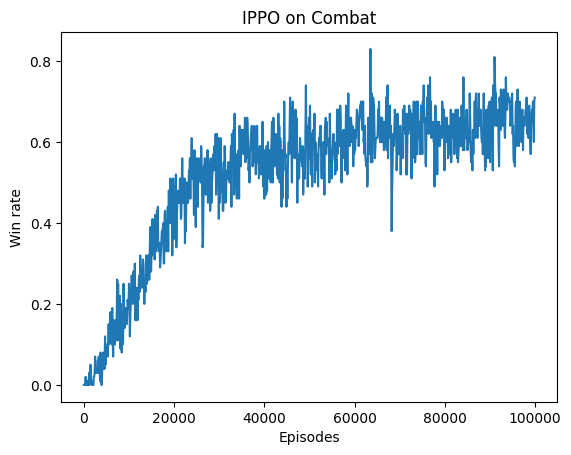

In [11]:
win_array = np.array(win_list)
# 100 条轨迹取一次平均
win_array = np.mean(win_array.reshape(-1, 100), axis=1)

episodes_list = np.arange(win_array.shape[0]) * 100
plt.plot(episodes_list, win_array)
plt.xlabel('Episodes')
plt.ylabel('Win rate')
plt.title('IPPO on Combat')
plt.show()
